
# Speech Recognition with Wav2Vec2

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to perform speech recognition using using
pre-trained models from wav2vec 2.0
[[paper](https://arxiv.org/abs/2006.11477)_].


## Overview

The process of speech recognition looks like the following.

1. Extract the acoustic features from audio waveform

2. Estimate the class of the acoustic features frame-by-frame

3. Generate hypothesis from the sequence of the class probabilities

Torchaudio provides easy access to the pre-trained weights and
associated information, such as the expected sample rate and class
labels. They are bundled together and available under
:py:mod:`torchaudio.pipelines` module.




## Preparation




In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.11.0+cu102
0.11.0+cu102
cpu


################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
import IPython
import matplotlib.pyplot as plt
#from torchaudio.utils import download_asset

#SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SPEECH_FILE = "raw-audio/QG_20230404144514_1_1071010_1342160_1283_32095.wav"

## Creating a pipeline

First, we will create a Wav2Vec2 model that performs the feature
extraction and the classification.

There are two types of Wav2Vec2 pre-trained weights available in
torchaudio. The ones fine-tuned for ASR task, and the ones not
fine-tuned.

Wav2Vec2 (and HuBERT) models are trained in self-supervised manner. They
are firstly trained with audio only for representation learning, then
fine-tuned for a specific task with additional labels.

The pre-trained weights without fine-tuning can be fine-tuned
for other downstream tasks as well, but this tutorial does not
cover that.

We will use :py:data:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H` here.

There are multiple pre-trained models available in :py:mod:`torchaudio.pipelines`.
Please check the documentation for the detail of how they are trained.

The bundle object provides the interface to instantiate model and other
information. Sampling rate and the class labels are found as follow.




In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


Model can be constructed as following. This process will automatically
fetch the pre-trained weights and load it into the model.




In [4]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


## Loading data

We will use the speech data from [VOiCES
dataset](https://iqtlabs.github.io/voices/)_, which is licensed under
Creative Commos BY 4.0.




In [5]:
IPython.display.Audio(SPEECH_FILE)

To load data, we use :py:func:`torchaudio.load`.

If the sampling rate is different from what the pipeline expects, then
we can use :py:func:`torchaudio.functional.resample` for resampling.

<div class="alert alert-info"><h4>Note</h4><p>- :py:func:`torchaudio.functional.resample` works on CUDA tensors as well.
   - When performing resampling multiple times on the same set of sample rates,
     using :py:class:`torchaudio.transforms.Resample` might improve the performace.</p></div>




In [6]:
def get_waveform(speech_file):
    waveform, sample_rate = torchaudio.load(speech_file)
    waveform = waveform.to(device)

    if sample_rate != bundle.sample_rate:
        waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
    return waveform

In [7]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

## Extracting acoustic features

The next step is to extract acoustic features from the audio.

<div class="alert alert-info"><h4>Note</h4><p>Wav2Vec2 models fine-tuned for ASR task can perform feature
   extraction and classification with one step, but for the sake of the
   tutorial, we also show how to perform feature extraction here.</p></div>




In [8]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

The returned features is a list of tensors. Each tensor is the output of
a transformer layer.




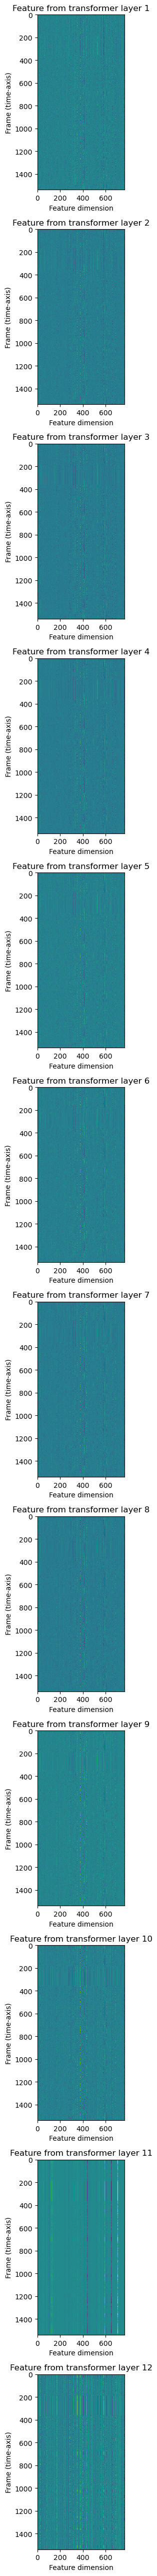

In [9]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

## Feature classification

Once the acoustic features are extracted, the next step is to classify
them into a set of categories.

Wav2Vec2 model provides method to perform the feature extraction and
classification in one step.




In [10]:
with torch.inference_mode():
    emission, _ = model(waveform)

The output is in the form of logits. It is not in the form of
probability.

Let’s visualize this.




Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


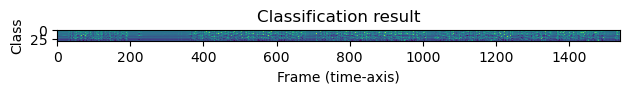

In [11]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

In [12]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsRegressor

In [13]:
df = pd.read_csv('./data-csv/tchatche_split_x.csv')
print(df.columns)
df.head(2)

Index(['file_name', 'rating', 'duration', 'transcript', 'speed',
       'intensity_avg', 'intensity_std', 'intensity_min', 'intensity_max',
       'pitch_avg', 'pitch_std', 'pitch_min', 'pitch_max', 'mfcc0_avg',
       'mfcc0_std', 'mfcc0_min', 'mfcc0_max', 'mfcc1_avg', 'mfcc1_std',
       'mfcc1_min', 'mfcc1_max', 'mfcc2_avg', 'mfcc2_std', 'mfcc2_min',
       'mfcc2_max'],
      dtype='object')


file_name  rating   duration  \
0  QG_20230404144514_1_1071010_1342160_1283_32095...       7  30.811774   
1  QG_20230404144514_1_1071010_1342160_39370_4386...       8   4.493384   

                                          transcript       speed  \
0  La parole est à Madame Sandra Rogol pour le gr...   21.420383   
1  En fait, toutes les personnes que vos réformes...  133.529662   

   intensity_avg  intensity_std  intensity_min  intensity_max   pitch_avg  \
0      61.986624       8.011046      38.471184      74.344699  277.552922   
1      58.555230      11.130439      40.060172      74.633179  257.859616   

   ...   mfcc0_min    mfcc0_max   mfcc1_avg   mfcc1_std  mfcc1_min  \
0  ...  332.228388  1682.642461  367.191824  133.774305 -70.096659   
1  ...  357.024724  1498.965527  380.027899  131.393800 -67.816469   

    mfcc1_max   mfcc2_avg  mfcc2_std   mfcc2_min  mfcc2_max  
0  608.373617 -189.272256   80.04866 -400.907286  53.735662  
1  578.667946 -193.903590   70.65459 -363.756655 -18.703706  

[2 rows x 25 columns]

In [14]:
def add_classification(wav_file):
    wav_file = f"raw-audio/{wav_file}"
    waveform = get_waveform(wav_file)
    #print(waveform)
    with torch.inference_mode():
        emission, _ = model(waveform)
    class_stt = emission[0].cpu().T
    return class_stt


In [15]:
df['file_name'].shape[0]

145

### Big compute

In [17]:
def compute_tensors(df):
    all_tensors = dict()
    for i in range(df['file_name'].shape[0]):
        filename = df['file_name'][i]
        try:
            all_tensors[filename] = add_classification(filename)
        except:
            print(f"can't compute for {filename}")
        #{filename : add_classification(df['file_name'][0])
    return all_tensors

all_tensors = compute_tensors(df.head())

In [18]:
df_old = df.copy()
df = df.loc[df['file_name'].isin(all_tensors.keys())]

In [19]:
serie_tensors = df['file_name'].apply(lambda filename : all_tensors[filename] if filename in all_tensors else None)

In [20]:
serie_tensors[0].shape

torch.Size([29, 1540])

In [21]:
serie_tensors.apply(lambda tensor : tensor[0].std().item() if tensor is not None else None)

0    3.282218
1    3.851864
2    3.365024
3    2.892691
4    2.778911
Name: file_name, dtype: float64

In [22]:
NAME_CLASS_WAV2VEC= 'class_wav'
for class_index in range(29):
    df[f'NAME_CLASS_WAV2VEC_{class_index}_mean'] = serie_tensors.apply(lambda tensor : tensor[class_index].mean().item() if tensor is not None else None)
    df[f'NAME_CLASS_WAV2VEC_{class_index}_min'] = serie_tensors.apply(lambda tensor : tensor[class_index].min().item() if tensor is not None else None)
    df[f'NAME_CLASS_WAV2VEC_{class_index}_max'] = serie_tensors.apply(lambda tensor : tensor[class_index].max().item() if tensor is not None else None)

    #df[f'NAME_CLASS_WAV2VEC_{class_index}_std'] = serie_tensors.apply(lambda tensor : tensor[class_index].mean().std() if tensor is not None else None)

/tmp/ipykernel_79306/237570294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'NAME_CLASS_WAV2VEC_{class_index}_mean'] = serie_tensors.apply(lambda tensor : tensor[class_index].mean().item() if tensor is not None else None)
/tmp/ipykernel_79306/237570294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'NAME_CLASS_WAV2VEC_{class_index}_min'] = serie_tensors.apply(lambda tensor : tensor[class_index].min().item() if tensor is not None else None)
/tmp/ipykernel_79306/237570294.py:5: SettingWith

<AxesSubplot:>

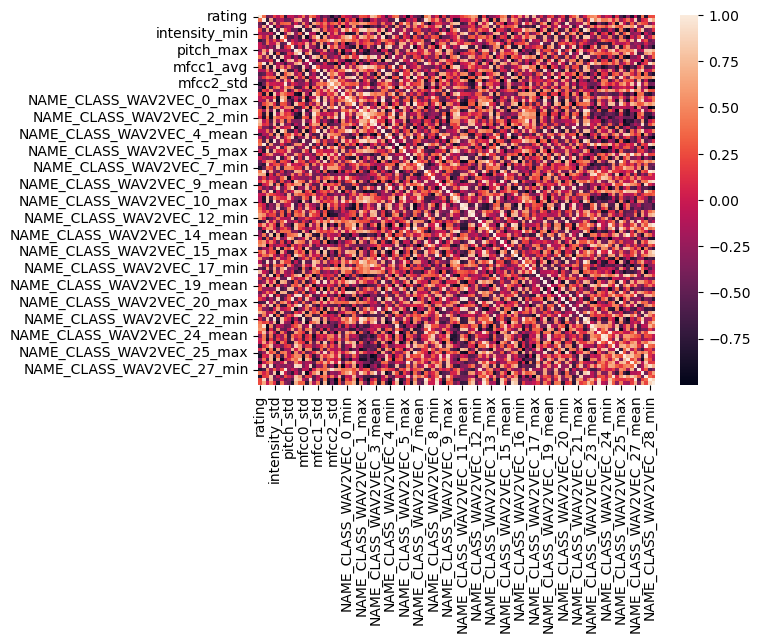

In [23]:
numerical_df = df.select_dtypes(include=['float64', 'int64'])
corr = numerical_df.corr()
sns.heatmap(corr)

In [24]:
abs(corr['rating']).sort_values(ascending=False).head(15)

rating                        1.000000
NAME_CLASS_WAV2VEC_6_mean     0.878622
NAME_CLASS_WAV2VEC_26_max     0.870168
mfcc2_std                     0.851199
NAME_CLASS_WAV2VEC_7_min      0.846159
NAME_CLASS_WAV2VEC_26_mean    0.835767
NAME_CLASS_WAV2VEC_12_max     0.799512
NAME_CLASS_WAV2VEC_28_mean    0.791932
NAME_CLASS_WAV2VEC_27_min     0.785950
NAME_CLASS_WAV2VEC_17_max     0.778797
NAME_CLASS_WAV2VEC_2_max      0.766623
NAME_CLASS_WAV2VEC_9_mean     0.741886
pitch_avg                     0.727886
NAME_CLASS_WAV2VEC_17_mean    0.724996
NAME_CLASS_WAV2VEC_21_max     0.714081
Name: rating, dtype: float64

In [25]:
list(corr.index[abs(corr['rating']) > 0.2].values)

['rating',
 'duration',
 'speed',
 'intensity_avg',
 'intensity_max',
 'pitch_avg',
 'pitch_max',
 'mfcc0_std',
 'mfcc0_min',
 'mfcc0_max',
 'mfcc1_avg',
 'mfcc1_min',
 'mfcc1_max',
 'mfcc2_avg',
 'mfcc2_std',
 'mfcc2_min',
 'mfcc2_max',
 'NAME_CLASS_WAV2VEC_1_mean',
 'NAME_CLASS_WAV2VEC_1_min',
 'NAME_CLASS_WAV2VEC_1_max',
 'NAME_CLASS_WAV2VEC_2_mean',
 'NAME_CLASS_WAV2VEC_2_max',
 'NAME_CLASS_WAV2VEC_3_mean',
 'NAME_CLASS_WAV2VEC_3_min',
 'NAME_CLASS_WAV2VEC_4_mean',
 'NAME_CLASS_WAV2VEC_4_max',
 'NAME_CLASS_WAV2VEC_5_mean',
 'NAME_CLASS_WAV2VEC_5_min',
 'NAME_CLASS_WAV2VEC_6_mean',
 'NAME_CLASS_WAV2VEC_6_max',
 'NAME_CLASS_WAV2VEC_7_mean',
 'NAME_CLASS_WAV2VEC_7_min',
 'NAME_CLASS_WAV2VEC_7_max',
 'NAME_CLASS_WAV2VEC_8_mean',
 'NAME_CLASS_WAV2VEC_8_min',
 'NAME_CLASS_WAV2VEC_9_mean',
 'NAME_CLASS_WAV2VEC_9_max',
 'NAME_CLASS_WAV2VEC_11_mean',
 'NAME_CLASS_WAV2VEC_11_min',
 'NAME_CLASS_WAV2VEC_11_max',
 'NAME_CLASS_WAV2VEC_12_mean',
 'NAME_CLASS_WAV2VEC_12_min',
 'NAME_CLASS_WAV2VEC_

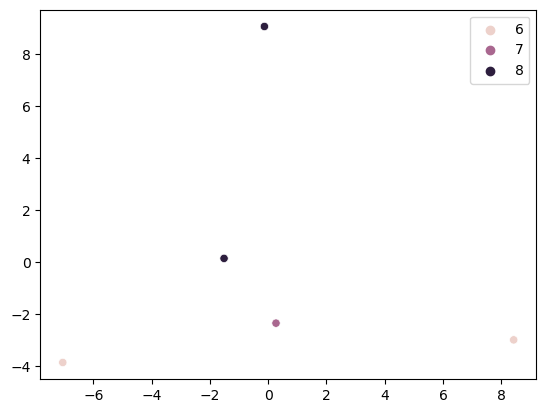

/home/thomas/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/thomas/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

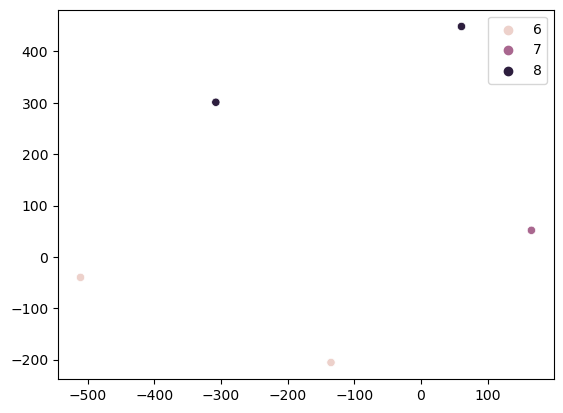

In [26]:
# drop the 'rating' column
#X = df.drop(['rating', 'file_name', 'transcript']+[f'NAME_CLASS_WAV2VEC_{index_col}_std' for index_col in range(29)], axis=1)

to_keep = [cl for cl in list(corr.index[abs(corr['rating']) > 0.2].values) if not cl =='rating']

X = df[to_keep]

# standardize the data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# get outlier indexes and remove
outlier_indexes = np.where((X_scaled > 3) | (X_scaled < -3))
X_clean = np.delete(X_scaled, outlier_indexes, axis=0)
rating = np.delete(df.rating.values, outlier_indexes, axis=0)

# perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_clean)

# plot the PCA results with color based on rating
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=rating)
plt.show()

# plot the tsne results with color based on rating
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_clean)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=rating)


In [27]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, rating, test_size=0.2, random_state=42)

In [31]:
# train a KNN model on the training set
knn = KNeighborsRegressor(n_neighbors=17)
knn.fit(X_train, y_train)

# use the trained model to predict the ratings for the testing set
y_pred = knn.predict(X_test)

# evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 17

# Retrain

In [ ]:
# Get the N most correlated features
nb_features = 10
not_correlated = []
#not_correlated = list(corr['rating'].abs().sort_values(ascending=False)[nb_features+1:].index)
X = df.drop(['file_name', 'rating', *not_correlated], axis=1)
X = df[to_keep]
# Remove not correlated features
corr['rating'].abs().sort_values()

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['rating'], test_size=0.2, random_state=42)

# train an XGBoost model on the training set
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    'max_depth': 11,
    'eta': 0.05,
    'objective': 'reg:squarederror'
}
model = xgb.train(params, dtrain)

# use the trained model to predict the ratings for the testing set
y_pred = model.predict(dtest)

# evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

# evaluate the performance of the model using mean squared error
median = [np.median(y_train) for _ in range(len(y_test))]
mse = mean_squared_error(y_test, median)
print('Mean squared error compared to median:', mse)